# Driverless AI - Training Time Series Model

The purpose of this notebook is to show an example of using Driverless AI to train a time series model.  Our goal will be to forecast the Weekly Sales for a particular Store and Department for the next week. The data used in this notebook is from the: [Walmart Kaggle Competition](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting). 

## Workflow

1. Import data into Python
2. Format data for Time Series
3. Upload data to Driverless AI
4. Launch Driverless AI Experiment
5. Evaluate model performance

## Step 1: Import Data

We will begin by importing our data using pandas. We are going to first work with the data in Python to correctly format it for a Driverless AI time series use case.

In [4]:
import pandas as pd

sales_data = pd.read_csv("./walmart_train.csv")
sales_data.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,sample_weight
0,1,1,2010-02-05,24924.50,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,False,1
1,1,2,2010-02-05,50605.27,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,False,1
2,1,3,2010-02-05,13740.12,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,False,1
3,1,4,2010-02-05,39954.04,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,False,1
4,1,5,2010-02-05,32229.38,42.31,2.572,-1.0,-1.0,-1.0,-1.0,-1.0,211.096358,8.106,False,1


In [5]:
# Convert Date column to datetime
sales_data["Date"] = pd.to_datetime(sales_data["Date"], format="%Y-%m-%d")

## Step 2: Format Data for Time Series

The data has one record per Store, Department, and Week.  Our goal for this use case will be to forecast the total sales for the next week.

The only features we should use as predictors are ones that we will have available at the time of scoring.  Features like the Temperature, Fuel Price, and Unemployment will not be known in advance.  Therefore, before we start our Driverless AI experiments, we will choose to use the previous week's Temperature, Fuel Price, Unemployment, and CPI attributes.  This information we will know at time of scoring.

In [6]:
lag_variables = ["Temperature", "Fuel_Price", "CPI", "Unemployment"]
dai_data = sales_data.set_index(["Date", "Store", "Dept"])
lagged_data = dai_data.loc[:, lag_variables].groupby(level=["Store", "Dept"]).shift(1)

In [8]:
# Join lagged predictor variables to training data
dai_data = dai_data.join(lagged_data.rename(columns=lambda x: x +"_lag"))

In [9]:
# Drop original predictor variables - we do not want to use these in the model 
dai_data = dai_data.drop(lagged_data, axis=1)
dai_data = dai_data.reset_index()

In [10]:
dai_data.head()

,Date,Store,Dept,Weekly_Sales,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,IsHoliday,sample_weight,Temperature_lag,Fuel_Price_lag,CPI_lag,Unemployment_lag
0,2010-02-05,1,1,24924.50,-1.0,-1.0,-1.0,-1.0,-1.0,False,1,NaN,NaN,NaN,NaN
1,2010-02-05,1,2,50605.27,-1.0,-1.0,-1.0,-1.0,-1.0,False,1,NaN,NaN,NaN,NaN
2,2010-02-05,1,3,13740.12,-1.0,-1.0,-1.0,-1.0,-1.0,False,1,NaN,NaN,NaN,NaN
3,2010-02-05,1,4,39954.04,-1.0,-1.0,-1.0,-1.0,-1.0,False,1,NaN,NaN,NaN,NaN
4,2010-02-05,1,5,32229.38,-1.0,-1.0,-1.0,-1.0,-1.0,False,1,NaN,NaN,NaN,NaN


Now that our training data is correctly formatted, we can run a Driverless AI experiment to forecast the next week's sales.

In [ ]:
def dai_moving_window(dataset, train_len, test_len, target, predictors, day_number_col, 
                      time_group_cols, accuracy, time, interpretability):
    
    
    windows = get_moving_windows(dataset, train_len, test_len, day_number_col)    
    
    # Split the data by the window
    forecast_predictions = pd.DataFrame([])
    model_descriptions = []
    model_features = []
    
    for window in windows:
        train_data = dataset[(dataset[day_number_col] >= window.get("train_start_index")) & 
                             (dataset[day_number_col] <= window.get("train_end_index"))]
        
        test_data = dataset[(dataset[day_number_col] >= window.get("test_start_index")) & 
                            (dataset[day_number_col] <= window.get("test_end_index"))]
        
        # Get the Driverless AI forecast predictions
        preds, desc, features = dai_get_forecast(train_data, test_data, predictors, target, 
                                                 day_number_col, time_group_cols, accuracy, time, interpretability)
        forecast_predictions = forecast_predictions.append(preds)
        model_descriptions = model_descriptions + [desc]
        model_features = model_features + [features]
    
    return forecast_predictions, model_descriptions, model_features

## Step 3: Upload Data to Driverless AI

We will split out data into two pieces: training and test (which consists of the last week of data).

In [11]:
train_data = dai_data.loc[dai_data["Date"] < "2012-10-26"]
test_data = dai_data.loc[dai_data["Date"] == "2012-10-26"]

To upload the datasets, we will sign into Driverless AI.

In [13]:
from h2oai_client import Client, ModelParameters

In [ ]:
address = 'http://ip_where_driverless_is_running:12345'
username = 'username'
password = 'password'
h2oai = Client(address = address, username = username, password = password)
# make sure to use the same user name and password when signing in through the GUI

In [12]:
train_path = "./train_data.csv"
test_path = "./test_data.csv"

train_data.to_csv(train_path, index = False)
test_data.to_csv(test_path, index = False)

In [13]:
# Add datasets to Driverless AI
train_dai = h2oai.upload_dataset_sync(train_path)
test_dai = h2oai.upload_dataset_sync(test_path)

#### Equivalent Steps in Driverless: Uploading Train & Test CSV Files
![Equivalent Steps in Driverless: Upload Train & Test CSV Files](images/import_data_sets_stock.png)

## Step 4: Launch Driverless AI Experiment

We will now launch the Driverless AI experiment.  To do that we will need to specify the parameters for our experiment.  Some of the parameters include:

* Target Column: The column we are trying to predict.
* Dropped Columns: The columns we do not want to use as predictors such as ID columns, columns with data leakage, etc.
* Is Time Series: Whether or not the experiment is a time-series use case.
* Time Column: The column that contains the date/date-time information.
* Time Group Columns: The categorical columns that indicate how to group the data so that there is one time series per group. In our example, our Time Groups Columns are `Store` and `Dept`.  Each `Store` and `Dept`, corresponds to a single time series.
* Number of Prediction Periods: How far in the future do we want to predict?
* Number of Gap Periods: After how many periods can we start predicting?  If we assume that we can start forecasting right after the training data ends, then the Number of Gap Periods will be 0.

For this experiment, we want to forecast next week's sales for each `Store` and `Dept`.  Therefore, we will use the following time series parameters: 

* Time Group Columns: `[Store, Dept]`
* Number of Prediction Periods: 1
* Number of Gap Periods: 0

In [14]:
experiment = h2oai.start_experiment_sync(dataset_key=train_dai.key,
                                         testset_key = test_dai.key,
                                         target_col="Weekly_Sales",
                                         is_classification=False,
                                         cols_to_drop = ["sample_weight"],
                                         accuracy=5,
                                         time=3,
                                         interpretability=1,
                                         scorer="RMSE",
                                         enable_gpus=True,
                                         seed=1234,
                                         time_col = "Date",
                                         time_groups_columns = ["Store", "Dept"],
                                         num_prediction_periods = 1,
                                         num_gap_periods = 0)

#### Equivalent Steps in Driverless: Launching Driverless AI Experiment
![Equivalent Steps in Driverless: Launching Driverless AI Experiment](images/launching_experiment.png)

## Step 5. Evaluate Model Performance

Now that our experiment is complete, we can view the model performance metrics within the experiment object.

In [15]:
print("Validation RMSE: ${:,.0f}".format(experiment.valid_score))
print("Test RMSE: ${:,.0f}".format(experiment.test_score))

Validation RMSE: $2,199
Test RMSE: $2,433


We can also plot the actual versus predicted values from the test data.

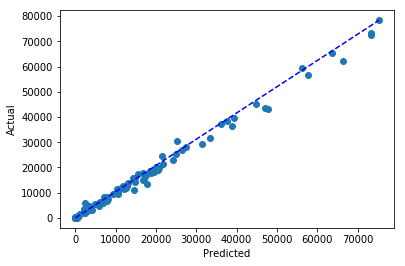

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.scatter(experiment.test_act_vs_pred.predicted, experiment.test_act_vs_pred.actual)
plt.plot([0, max(experiment.test_act_vs_pred.predicted)],[0, max(experiment.test_act_vs_pred.actual)], 'b--',)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Lastly, we can download the test predictions from Driverless AI and examine the forecasted sales vs actual for a selected store and department.

In [17]:
preds_path = h2oai.download(src_path=experiment.test_predictions_path, dest_dir=".")
forecast_predictions = pd.read_csv(preds_path)
forecast_predictions.columns = ["predicted_Weekly_Sales"]

actual = test_data[["Date", "Store", "Dept", "Weekly_Sales"]].reset_index(drop = True)
forecast_predictions = pd.concat([actual, forecast_predictions], axis = 1)
forecast_predictions.head()

,Date,Store,Dept,Weekly_Sales,predicted_Weekly_Sales
0,2012-10-26,1,1,27390.81,29016.900
1,2012-10-26,1,2,43134.88,42700.937
2,2012-10-26,1,3,9350.90,9351.535
3,2012-10-26,1,4,36292.60,34871.164
4,2012-10-26,1,5,25846.94,23360.783


In [26]:
selected_ts = sales_data.loc[(sales_data["Store"] == 1) & (sales_data["Dept"] == 1)].tail(n = 51)

selected_ts_forecast = forecast_predictions.loc[(forecast_predictions["Store"] == 1) & 
                                                (forecast_predictions["Dept"] == 1)]

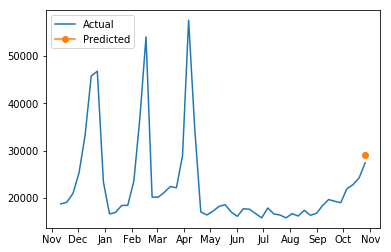

In [27]:
# Plot the forecast of a select store and department

import matplotlib.dates as mdates

years = mdates.MonthLocator() 
yearsFmt = mdates.DateFormatter('%b')

fig, ax = plt.subplots()
ax.plot(selected_ts["Date"], selected_ts["Weekly_Sales"], label = "Actual")
ax.plot(selected_ts_forecast["Date"], selected_ts_forecast["predicted_Weekly_Sales"], marker='o', label = "Predicted")
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
plt.legend(loc='upper left')
plt.show()